### Подключение к БД

In [ ]:
# установка библиотеки SQLAlchemy
!pip install sqlalchemy

In [2]:
# установка библиотеки psycopg2
!pip install psycopg2

In [11]:
# испорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

In [4]:
# записываем данные для подключения с БД в удобный формат
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
} 

In [5]:
# формируем строку для соединения через функцию .format()
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [6]:
# создаём соединение с БД
engine = create_engine(connection_string) 

### Визуализация Retention Rate

In [7]:
# записываем в переменную запрос для расчета Retention Rate
query = '''
WITH profile AS
  (SELECT user_id,
          dt,
          COUNT(*) OVER (PARTITION BY dt) AS cohort_users_cnt
   FROM online_store.profiles
   WHERE channel = 'Organic'),
sessions AS 
(SELECT user_id,
        session_start::date AS session_date
FROM online_store.sessions
GROUP BY 1,
         2)
SELECT p.dt AS cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4
'''

In [8]:
# записываем в переменную результат(таблицу) SQL-запроса из переменной `query`
retention_rate_df = pd.read_sql_query(query, con = engine) 

In [9]:
retention_rate_df.head()

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2020-06-14,2020-06-14,5098,5098,100.00
1,2020-06-14,2020-06-15,2647,5098,51.92
2,2020-06-14,2020-06-16,1836,5098,36.01
3,2020-06-14,2020-06-17,1403,5098,27.52
4,2020-06-14,2020-06-18,1085,5098,21.28


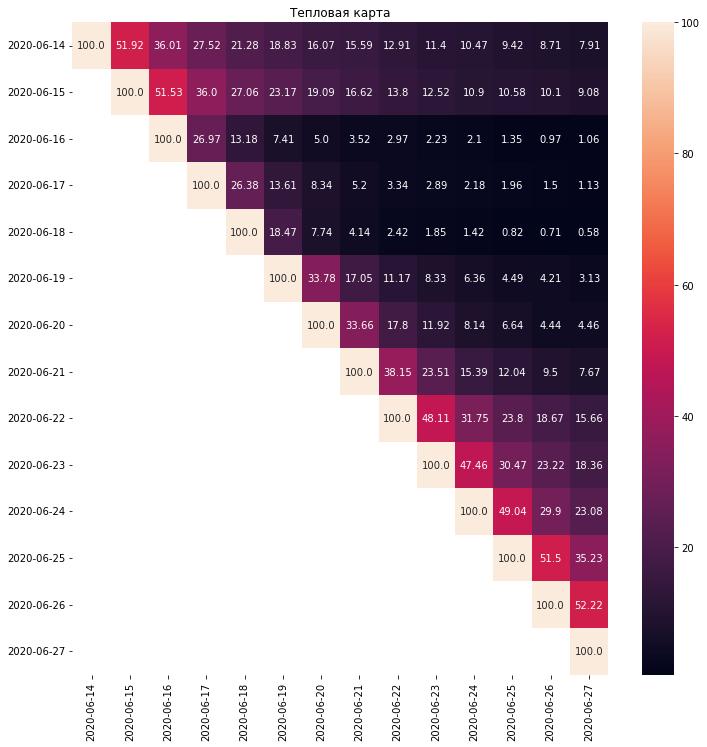

In [15]:
# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(12, 12)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

### Визуализация Churn Rate

In [16]:
query = '''
WITH profile AS
  (SELECT u.user_id,
          DATE_TRUNC('month', MIN(event_time))::date AS start_mn
   FROM tools_shop.users u
   JOIN tools_shop.orders o ON u.user_id = o.user_id
   JOIN tools_shop.events e ON u.user_id = e.user_id
   GROUP BY 1), 
sessions AS
  (SELECT start_mn,
          DATE_TRUNC('month', event_time)::date AS event_mn,
          COUNT(DISTINCT p.user_id) AS users_cnt
   FROM profile p
   JOIN tools_shop.events e ON p.user_id = e.user_id
   GROUP BY 1,
            2)
SELECT start_mn,
       event_mn,
       users_cnt,
       LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn) AS previous_day_users_cnt,
       ROUND((1 - (users_cnt::numeric / LAG(users_cnt) OVER (PARTITION BY start_mn ORDER BY event_mn))) * 100, 2) AS churn_rate
FROM sessions
WHERE start_mn BETWEEN '2018-01-01' AND '2018-06-01'
  AND event_mn BETWEEN '2018-01-01' AND '2018-12-01';
'''

In [17]:
churn_rate_df = pd.read_sql_query(query, con = engine)

In [18]:
churn_rate_df.head()

,start_mn,event_mn,users_cnt,previous_day_users_cnt,churn_rate
0,2018-01-01,2018-01-01,257,NaN,NaN
1,2018-01-01,2018-02-01,67,257.0,73.93
2,2018-01-01,2018-03-01,41,67.0,38.81
3,2018-01-01,2018-04-01,44,41.0,-7.32
4,2018-01-01,2018-05-01,42,44.0,4.55


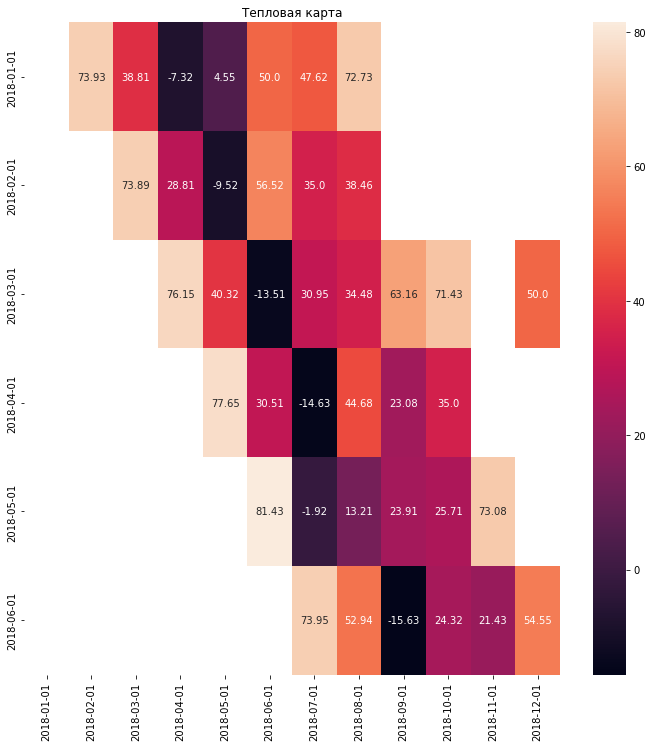

In [20]:
# создаём сводную таблицу с результатами
churn_rate = churn_rate_df.pivot('start_mn', 'event_mn', 'churn_rate')
churn_rate.index = [str(x)[0:10] for x in churn_rate.index]
churn_rate.columns = [str(x)[0:10] for x in churn_rate.columns]

# строим хитмэп
plt.figure(figsize=(12, 12)) # задаём размер графика
sns.heatmap(churn_rate, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()